In [1]:
import os
import tensorflow as tf
from tokenization_bert import BertTokenizer
from modeling_tf_bert import TFBertForSequenceClassification

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

In [2]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
# Load dataset, tokenizer, model from pretrained model/vocabulary

# bert_checkpoint_path = "larva-kor-plus-base-cased-pytorch/"
# tokenizer = BertTokenizer.from_pretrained(bert_checkpoint_path)
# model = TFBertForSequenceClassification.from_pretrained(bert_checkpoint_path, from_pt=True)

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased') #토크나이저 불러오기
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased') # 모델 학습 불러오기

In [35]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 16
NUM_EPOCHS = 5
VALID_SPLIT = 0.2
MAX_LEN = 50
DATA_OUT_PATH = "data_out/"
model_name = "tf2_bert"

In [36]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[MASK]', '[PAD]', '[SEP]', '[CLS]'] 
 [100, 103, 0, 102, 101]
[101, 1174, 26646, 49345, 13045, 35132, 25169, 47024, 117, 1170, 26646, 11376, 17360, 13212, 79427, 102]
[101, 29155, 10228, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]
[CLS] hello world [SEP]


In [37]:
# 데이터 전처리 준비

DATA_PATH = '/Users/user/github/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/'
DATA_TRAIN_PATH = DATA_PATH + "ratings_train.txt"
DATA_TEST_PATH = DATA_PATH + "ratings_test.txt"

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [38]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [39]:
# train_data = train_data[:1000] # for test

train_data_sents = []
train_data_labels = []

for train_sent, train_label in zip(train_data["document"], train_data["label"]):
    try:
        token_sent = tokenizer.encode(clean_text(train_sent))
        train_data_sents.append(token_sent)
        train_data_labels.append(train_label)
    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_data_sent_pads = np.asarray(pad_sequences(train_data_sents, maxlen=MAX_LEN, padding='post'), dtype=np.int32) # convert into numpy
train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(train_data_sent_pads), len(train_data_labels)))

expected string or bytes-like object
nan
expected string or bytes-like object
nan
expected string or bytes-like object
nan
expected string or bytes-like object
nan
expected string or bytes-like object
nan
num sents, labels 149995, 149995


In [40]:
print(train_data_sent_pads[0])

[  101  1174 25539 23236 29234 13045 87550 97082 25539  1176 25539 24937
 13045 16801 72197 47024  1169 70724 22585 13926   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [41]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [42]:
# model.save_pretrained("bert_checkpoint/") # 모델 프리트레인 저장하기
model.summary() #모델 파라메터 수 체크

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  167356416 
_________________________________________________________________
dropout_151 (Dropout)        multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 167,357,954
Trainable params: 167,357,954
Non-trainable params: 0
_________________________________________________________________


In [43]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_sent_pads, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback], validation_steps=2)

#steps_for_epoch

print(history.history)

data_out/tf2_bert -- Folder already exists 

Train on 119996 samples, validate on 29999 samples
Epoch 1/5
119984/119996 [============================>.] - ETA: 2s - loss: 0.4370 - accuracy: 0.7893
Epoch 00001: val_accuracy improved from -inf to 0.71875, saving model to data_out/tf2_bert/weights.01-0.72.h5
119996/119996 [==============================] - 22593s 188ms/sample - loss: 0.4370 - accuracy: 0.7893 - val_loss: 6.2147e-04 - val_accuracy: 0.7188
Epoch 2/5
119984/119996 [============================>.] - ETA: 2s - loss: 0.3450 - accuracy: 0.8470
Epoch 00002: val_accuracy did not improve from 0.71875
119996/119996 [==============================] - 21859s 182ms/sample - loss: 0.3450 - accuracy: 0.8470 - val_loss: 8.3198e-04 - val_accuracy: 0.6562
{'loss': [0.4369786576252706, 0.3450103037831958], 'accuracy': [0.78930134, 0.84697825], 'val_loss': [0.0006214711081087956, 0.0008319766804625096], 'val_accuracy': [0.71875, 0.65625]}


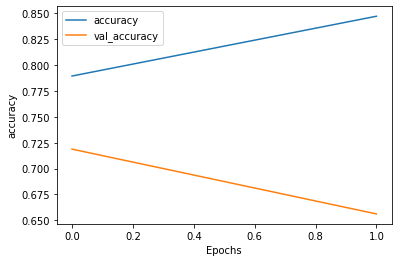

In [44]:
plot_graphs(history, 'accuracy')

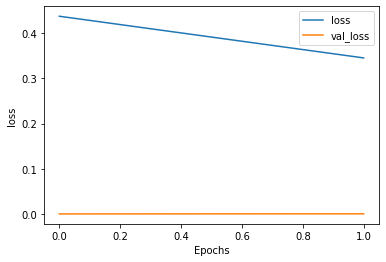

In [45]:
plot_graphs(history, 'loss')

# Test 데이터

In [31]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [32]:
test_data = test_data[:1000] # for test

test_data_sent = [tokenizer.encode(clean_text(test_sent)) for test_sent in test_data["document"]] #문장 토크나이징 리스트 
test_data_sent_pad = np.asarray(pad_sequences(test_data_sent, maxlen=MAX_LEN), dtype=np.int32) # convert into numpy
test_data_label = np.asarray(test_data["label"], dtype=np.int32) #레이블 토크나이징 리스트

In [33]:
results = model.evaluate(test_data_sent_pad, test_data_label)
print("test loss, test acc: ", results)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

test loss, test acc:  [0.6946040930747985, 0.508]
